In [1]:
import h5py
import torch
import matplotlib.pyplot as plt
import seaborn as sns

torch.set_grad_enabled(False)
torch.set_default_device("cuda")

U = None
T = None
n_samples = 0

with h5py.File("./data/RB_64_96_U.h5", "r") as f:
    n_samples = len(f["u0"]["2D"]) 
    U = torch.empty((n_samples, 2, 64, 96))

    for k in range(n_samples):
        U[k,0,:,:] = torch.tensor( f["u0"]["2D"][f"{k+1}"][:] )
        U[k,1,:,:] = torch.tensor( f["u1"]["2D"][f"{k+1}"][:] )

with h5py.File("./data/RB_64_96_T.h5", "r") as f:
    T = torch.empty((n_samples, 64, 96))
    for k in range(n_samples):
        T[k,:,:] = torch.tensor( f["T"]["2D"][f"{k+1}"][:] )

/upb/users/h/harderh/profiles/unix/cs/miniconda3/envs/ELM-PDEs/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [130]:
X = torch.cat((U,T[:,None,:,:]),dim=1)
i = 700-1
Y = X[i:i+1,:,:,:].double()
X = X[i+1:i+2,:,:,:].double()

In [131]:
# BC's for RBC
# Velocity:
# for i = 0,1, j=0,-1:
# - X[:,i,j,:] = 0 (bottom, top, Dirichlet)
# Temperature:
# - X[:,2,0,:] = 1 (bottom, Dirichlet)
# - X[:,2,-1,:] = 0 (top, Dirichlet)
# - X[:,:,:,0] = X[:,:,:,-1] (left, right, periodic)
class RBC2DModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.__is_trained = False
        self.model = model

    def train(self, X, Y, **kwargs):
        n_channels = X.shape[1]
        self.X_min = torch.tensor([ X[:,k,:,:].min() for k in range(n_channels) ])
        self.X_max = torch.tensor([ X[:,k,:,:].max() for k in range(n_channels) ])
        self.X_min = self.X_min.view(1,n_channels,1,1)
        self.X_max = self.X_max.view(1,n_channels,1,1)

        self.model.train(
            self.data_to_input(X), 
            self.data_to_output(X, Y), 
            **kwargs)

        self.__is_trained = True

    def data_to_input(self, X):
        return X
        X = (X - self.X_min) / (self.X_max - self.X_min)
        return X

    def data_to_output(self, X, Y):
        return Y
        Y = (Y - self.X_min) / (self.X_max - self.X_min)
        return Y

    def output_to_data(self, X, Y):
        return Y
        Y = Y * (self.X_max - self.X_min) + self.X_min
        return Y

    def forward(self, X):
        assert self.__is_trained
        squeezed = len(X.shape) == 3
        if squeezed: X = X.unsqueeze(0)

        Y = self.data_to_input(X)
        Y = self.model(Y)
        Y = self.output_to_data(X, Y)

        if squeezed: Y = Y.squeeze(0)
        return Y

class ELM2D(torch.nn.Module):
    def __init__(self, extent, step, in_channels, hidden, out_channels):
        super().__init__()
        self.hidden = hidden
        self.step = torch.tensor(step)
        self.extent = torch.tensor(extent)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.ks = self.step+2*self.extent

        self.lin = torch.nn.Linear(self.in_channels * self.ks.prod().item(), self.hidden, dtype=torch.float64, bias=True)
        self.nl = torch.nn.Softplus()
        self.lout = torch.nn.Linear(self.hidden, self.out_channels * self.step.prod().item(), dtype=torch.float64, bias=False)
        
    def phi(self, X):
        return self.nl(self.lin(X))
        
    def pad(self, X):
        n_samples, n_channels, n_x, n_y = X.shape

        # adds periodic boundary conditions
        X_padded = torch.cat((X[:,:,:, -self.extent[1]:], X, X[:,:,:, :self.extent[1]]), dim=3)

        # adds constant terms
        n_y_padded = n_y + 2*self.extent[1]
        U_bc = torch.zeros((n_samples, 2, self.extent[0], n_y_padded))
        T_bc_top = torch.zeros((n_samples, 1, self.extent[0], n_y_padded))
        T_bc_btm =  torch.ones((n_samples, 1, self.extent[0], n_y_padded))
        bc_btm = torch.cat((U_bc, T_bc_btm), dim=1)
        bc_top = torch.cat((U_bc, T_bc_top), dim=1)

        X_padded = torch.cat((bc_btm, X_padded, bc_top), dim=2)
        return X_padded

    def batched(self, X):
        # X = X.unsqueeze(1)
        X = torch.nn.functional.unfold(X, self.ks, stride=self.step)
        X = X.permute((0,2,1))
        return X
    
    def unbatch(self, X, output_dim):
        X = X.permute((0,2,1))
        X = torch.nn.functional.fold(X, output_dim, self.step, stride=self.step)
        # X = X.squeeze(1)
        return X

    def forward(self, X):
        D = torch.tensor(X.shape[2:])
        assert (D % self.step == 0).all()

        # X = apply_symmetries(X, nr_symmetries)
        # X = X.view(-1, *X.shape[2:])

        X = self.pad(X)
        X = self.batched(X)
        X = self.lout(self.phi(X))
        X = self.unbatch(X, D)

        # X = X.view(-1, nr_symmetries, *X.shape[1:])
        # X = apply_symmetries(X, nr_symmetries, inv=True)
        # X = X.mean(dim=1)

        return X

    def train(self, X, Y, stopping_threshold=1e-5, noise=1e-4, logging=True, callback=None):
        bs, _, N0, N1 = X.shape
        # X = apply_symmetries(X, nr_symmetries=nr_symmetries)
        # Y = apply_symmetries(Y, nr_symmetries=nr_symmetries)

        if noise > 0: noise_distr = torch.distributions.Normal(0,noise)

        E_PhiTPhi = 0
        E_PhiTY = 0
        change = None
        k = 0

        while change is None or change > stopping_threshold:
            # selects a random position
            i = torch.randint(bs,(1,))[0]
            j0 = torch.randint(N0-self.ks[0],(1,))[0]
            j1 = torch.randint(N1-self.ks[1],(1,))[0]

            # selects the appropriate windows
            X_train = X[i,   :, j0:j0+self.ks[0],
                                j1:j1+self.ks[1]]
            Y_train = Y[i,   :, j0+self.extent[0]:j0+self.ks[0]-self.extent[0],
                                j1+self.extent[1]:j1+self.ks[1]-self.extent[1]]
            
            X_train = X_train.reshape(-1,self.in_channels*self.ks[0]*self.ks[1])
            Y_train = Y_train.reshape(-1,self.out_channels*self.step[0]*self.step[1])

            # adds noise -> increases robustness
            if noise > 0: X_train += noise_distr.sample(X_train.shape) 
            Phi = self.phi(X_train).detach()

            alpha = 1/(k+1)
            E_PhiTPhi_ =  (1-alpha)*E_PhiTPhi  + alpha*(Phi.T @ Phi)
            E_PhiTY_   =  (1-alpha)*E_PhiTY    + alpha*(Phi.T @ Y_train)
            target = ((E_PhiTPhi_-E_PhiTPhi).pow(2).sum() + (E_PhiTY_-E_PhiTY  ).pow(2).sum())
            if change is None: change = target
            else: change = 0.95*change + 0.05*target
            if logging: print(f"change = {change:.6f}", end="\r")
            if change < stopping_threshold: break
            E_PhiTPhi, E_PhiTY = E_PhiTPhi_, E_PhiTY_ 
            if callback is not None and k > 1: 
                A = torch.linalg.solve(E_PhiTPhi, E_PhiTY)
                self.lout.weight.data = A.transpose(0,1)
                callback(k, change, self)
            k += 1

        A = torch.linalg.solve(E_PhiTPhi, E_PhiTY)
        self.lout.weight.data = A.transpose(0,1)

In [169]:
wrapper = RBC2DModelWrapper(ELM2D((2,2), (2,2), 3, 200, 3))
wrapper.train(wrapper.model.pad(X), wrapper.model.pad(Y), stopping_threshold=1e-3, noise=0)
# wrapper.train(X, Y, stopping_threshold=1e-3, noise=1e-3)

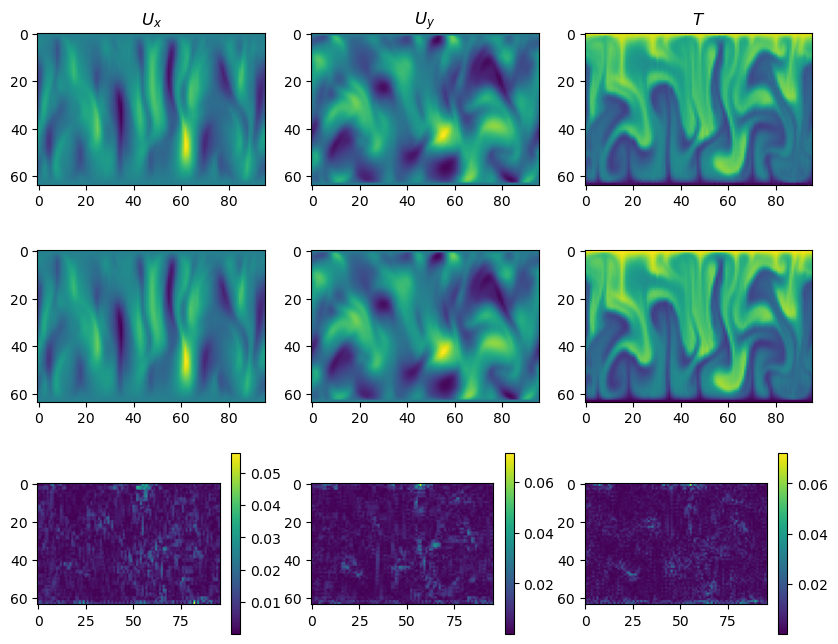

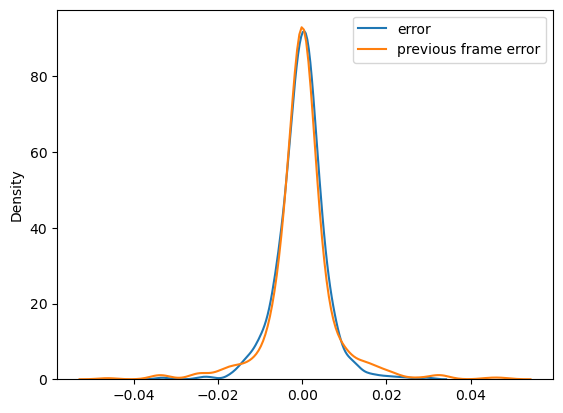

In [170]:
Y_pred = wrapper(X)
error = Y-Y_pred # .abs()
prev_img_error = Y - X

fig, ax = plt.subplots(3,3,figsize=(10,8))
for i in range(3):
    ax[0,i].imshow(Y_pred[0,i,:,:].cpu())
    ax[0,i].set_title(["$U_x$", "$U_y$", "$T$"][i])
    ax[1,i].imshow(Y[0,i,:,:].cpu())
    plt.colorbar( ax[2,i].imshow(error[0,i,:,:].abs().cpu()) )
plt.show()

sns.kdeplot(error[:,2,:,:].flatten().cpu().numpy()[::10], label="error")
sns.kdeplot(prev_img_error[:,2,:,:].flatten().cpu().numpy()[::10], label="previous frame error")
plt.legend()
plt.show()

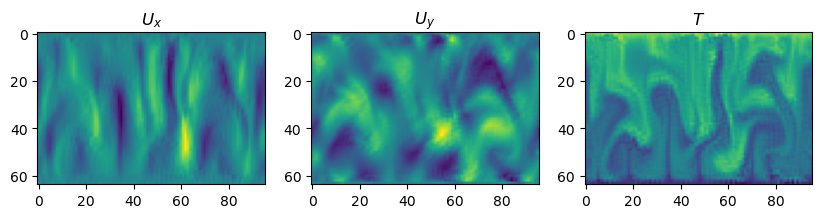

In [176]:
X_tmp = X[-1,:,:,:]
for k in range(5):
    X_tmp = wrapper(X_tmp)

fig, ax = plt.subplots(1,3,figsize=(10,8))
for i in range(3):
    ax[i].imshow(X_tmp[i,:,:].cpu())
    ax[i].set_title(["$U_x$", "$U_y$", "$T$"][i])